# Figure 8: Forced Response and Delayed Warming in EPT

In [2]:
import os
import cartopy
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore as xscore

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Tuple

# Plotting Utils

In [3]:
def _global_plot(
    ax, 
    data, 
    lon, 
    lat, 
    cmap, 
    pvalues=None, 
    right_title="", 
    left_title="", 
    levels=np.arange(-4, 4.1, .1), 
    cbar_label: str = "",
):
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        # colors=cmap, # uncomment for reds
        cmap=cmap,
        extend="both",
        levels=levels,
    )

    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
    
        
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Southern Ocean
    bound_region(ax, lons=(-180, -75), lats=(-70, -50), color="black")

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -90, 90
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # add cbar label to top of colorbar
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.030, pad=0.02)
    cbar.ax.set_title(cbar_label, fontsize=10)

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

In [4]:
def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)

def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def get_triangle(tos, latmin: float = -38.75, latmax: float = -1.25, lonmin: float = -178.75, lonmax: float = -71.25, RES: float = 2.5):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ctos = tos.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))
    nmodel, ntime, _, nlon = ctos.shape

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == nlon: break

        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
             
        nlats = int(len(latcoords) - j) # nlats below diag
        ctos[:,:,:nlats,i] = np.full((nmodel, ntime, nlats), np.nan) 
        
        jold = j
    
    return ctos


# Load Data

In [5]:
DATA_ROOT = "/home/espinosa10/SO-EP-teleconnection/Data"

# 4xCO2
sst_cmip6_4xc02 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/4xCO2/tos_mon_150yrs_CMIP6_4xCO2.nc")
sst_cmip5_4xc02 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/4xCO2/tos_mon_150yrs_CMIP5_4xCO2.nc")
sst_cmip_4xc02 = fix_coords(xr.concat([sst_cmip6_4xc02, sst_cmip5_4xc02], dim="model"))

cmip_4xc02_ept_sst = fix_coords(get_triangle(sst_cmip_4xc02.tos.copy(deep=True)).to_dataset()).spatial.average("tos")
cmip_4xc02_so_sst = sst_cmip_4xc02.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("tos")
cmip_4xc02_global_sst = sst_cmip_4xc02.spatial.average("tos")

# dEPT/dSO at variance timescales: CMIP
rvalues_so_ept_coupling = xr.open_dataset(os.path.join(DATA_ROOT, "so_ept_coupling.nc"))

For each latitude step of 2.5 degrees, longitude step is 7.5


In [15]:
early_slice = slice(0, 12*19)
late_slice = slice(12*20, 12*150)
sst_cmip_4xc02_early = sst_cmip_4xc02.isel(time=early_slice)["tos"].resample(time="1Y").mean("time")
sst_cmip_4xc02_late = sst_cmip_4xc02.isel(time=late_slice)["tos"].resample(time="1Y").mean("time")
sst_cmip_4xc02_late = sst_cmip_4xc02.isel(time=late_slice)["tos"].resample(time="1Y").mean("time")

global_cmip_4xc02_early = cmip_4xc02_global_sst.isel(time=early_slice)["tos"].resample(time="1Y").mean("time")
global_cmip_4xc02_late = cmip_4xc02_global_sst.isel(time=late_slice)["tos"].resample(time="1Y").mean("time")

# Group by models with high and low coupling
so_ept_coupling_5year = rvalues_so_ept_coupling.reg.sel(years=12*5)
so_ept_coupling_5year, sst_cmip_4xc02 = get_shared_models(so_ept_coupling_5year, sst_cmip_4xc02)

global_cmip_4xc02_late = global_cmip_4xc02_late.sel(model=sst_cmip_4xc02.model)
global_cmip_4xc02_early = global_cmip_4xc02_early.sel(model=sst_cmip_4xc02.model)

bottom_half_coupling = so_ept_coupling_5year[so_ept_coupling_5year < so_ept_coupling_5year.median()]
top_half_coupling = so_ept_coupling_5year[so_ept_coupling_5year >= so_ept_coupling_5year.median()]

# Early All
early = xscore.linslope(global_cmip_4xc02_early, sst_cmip_4xc02_early, dim="time").mean("model")
# Early Low Coupling
early_low = sst_cmip_4xc02_early.sel(model=bottom_half_coupling.model)
early_low = xscore.linslope(global_cmip_4xc02_early.sel(model=bottom_half_coupling.model), early_low, dim="time").mean("model")
# Early High Coupling
early_high = sst_cmip_4xc02_early.sel(model=top_half_coupling.model)
early_high = xscore.linslope(global_cmip_4xc02_early.sel(model=top_half_coupling.model), early_high, dim="time").mean("model")
# Late All
late = xscore.linslope(global_cmip_4xc02_late, sst_cmip_4xc02_late, dim="time").mean("model")
# Late Low Coupling
late_low = sst_cmip_4xc02_late.sel(model=bottom_half_coupling.model)
late_low = xscore.linslope(global_cmip_4xc02_late.sel(model=bottom_half_coupling.model), late_low, dim="time").mean("model")
# Late High Coupling
late_high = sst_cmip_4xc02_late.sel(model=top_half_coupling.model)
late_high = xscore.linslope(global_cmip_4xc02_late.sel(model=top_half_coupling.model), late_high, dim="time").mean("model")

# Figure 7

/tmp/ipykernel_3457092/276479326.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


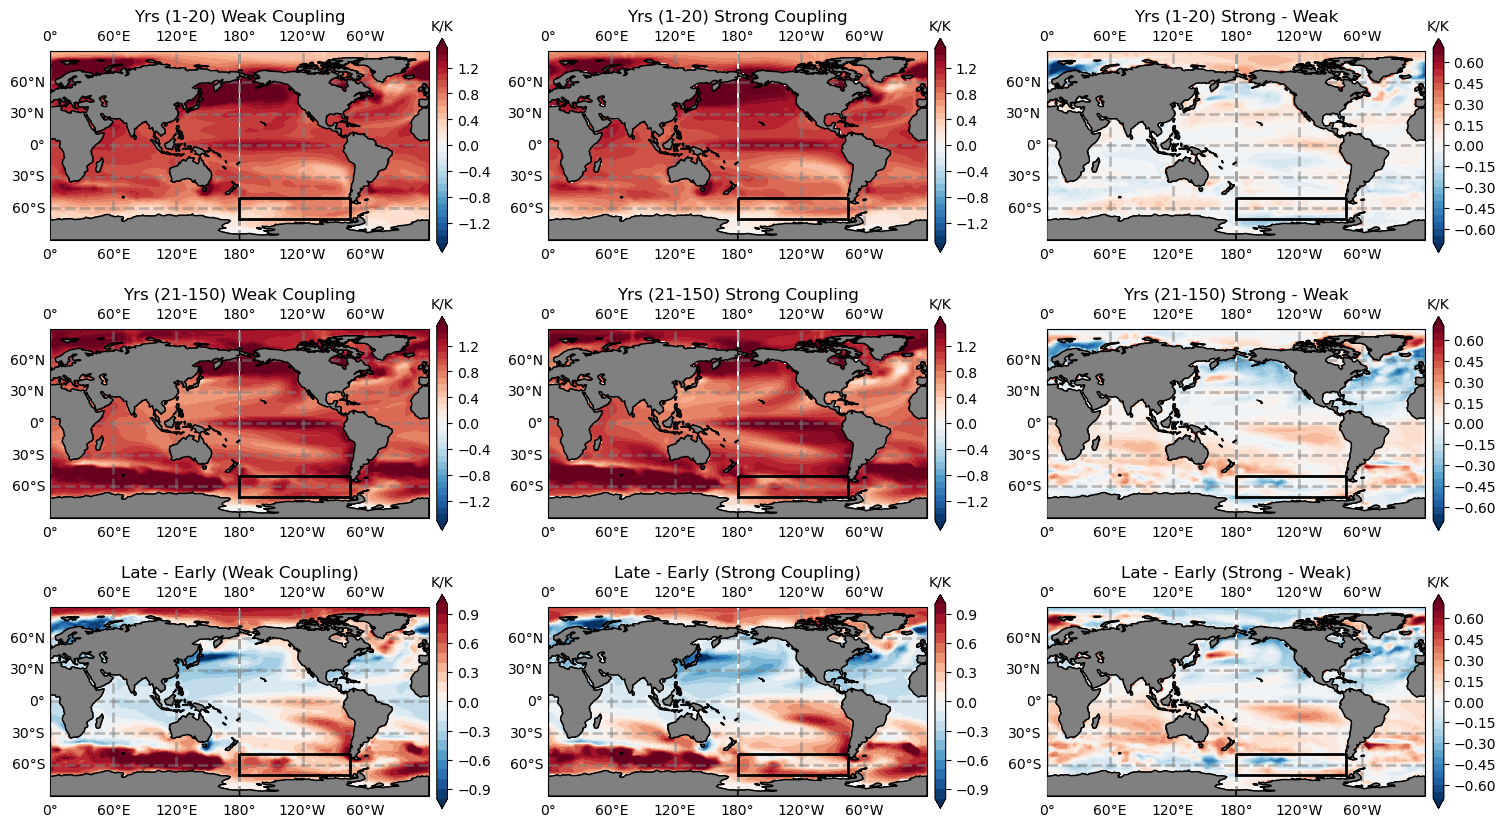

In [23]:
# Create a figure and define a GridSpec with three rows and three columns
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(3, 3, wspace=0.25, hspace=0.30)

# Define the levels and colormap for the plots
levels = np.arange(-2, 2.1, 0.1)
diff_levels = np.arange(-1, 1.1, 0.1)
col3_levels = np.arange(-.70, .75, 0.05)
warming_levels = np.arange(-1.5, 1.6, 0.1)
cmap = "RdBu_r"

# Plot early_low
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax1, data=early_low.values, lat=early_low.lat, lon=early_low.lon, levels=warming_levels, cmap=cmap, cbar_label="K/K")
ax1.set_title(r"Yrs (1-20) Weak Coupling")

# Plot early_high
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax2, data=early_high.values, lat=early_high.lat, lon=early_high.lon, levels=warming_levels, cmap=cmap, cbar_label="K/K")
ax2.set_title(r"Yrs (1-20) Strong Coupling")

# Plot difference between early_high and early_low
ax3 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax3, data = (early_high - early_low).values, lat=early_low.lat, lon=early_low.lon, levels=col3_levels, cmap=cmap, cbar_label="K/K")
ax3.set_title(r"Yrs (1-20) Strong - Weak")

# Plot late_low
ax4 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax4, data=late_low.values, lat=late_low.lat, lon=late_low.lon, levels=warming_levels, cmap=cmap, cbar_label="K/K")
ax4.set_title(r"Yrs (21-150) Weak Coupling")

# Plot late_high
ax5 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax5, data=late_high.values, lat=late_high.lat, lon=late_high.lon, levels=warming_levels, cmap=cmap, cbar_label="K/K")
ax5.set_title(r"Yrs (21-150) Strong Coupling")

# Plot difference between late_high and late_low
ax6 = fig.add_subplot(gs[1, 2], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax6, data=(late_high - late_low).values, lat=late_low.lat, lon=late_low.lon, levels=col3_levels, cmap=cmap, cbar_label="K/K")
ax6.set_title(r"Yrs (21-150) Strong - Weak")

# Plot difference between early_low and late_low
ax7 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax7, data=(late_low - early_low).values, lat=early_low.lat, lon=early_low.lon, levels=diff_levels, cmap=cmap, cbar_label="K/K")
ax7.set_title(r"Late - Early (Weak Coupling)")

# Plot difference between early_high and late_high
ax8 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax8, data=(late_high - early_high).values, lat=early_high.lat, lon=early_high.lon, levels=diff_levels, cmap=cmap, cbar_label="K/K")
ax8.set_title(r"Late - Early (Strong Coupling)")

# Plot difference between (early_high - early_low) and (late_high - late_low)
ax9 = fig.add_subplot(gs[2, 2], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax9, data=((late_high - late_low) - (early_high - early_low)).values, lat=early_low.lat, lon=early_low.lon, levels=col3_levels, cmap=cmap, cbar_label="K/K")
ax9.set_title(r"Late - Early (Strong - Weak)")

#########################################################################
plt.tight_layout()
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_7.png", dpi=300, bbox_inches="tight")
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_7.pdf", dpi=300, bbox_inches="tight")

# Figure SX - Plot Early / Late without Grouping at all

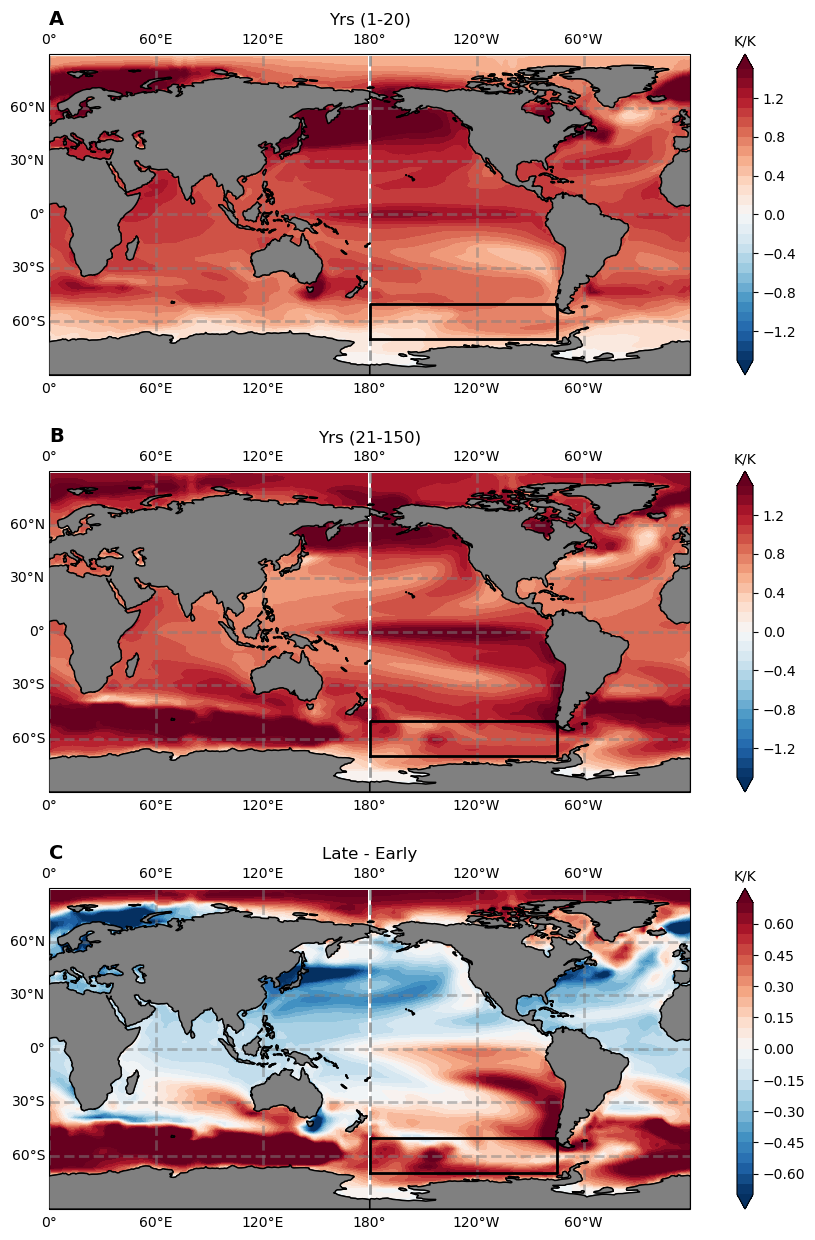

In [20]:
# Create a figure and define a GridSpec with three rows and three columns
fig = plt.figure(figsize=(30, 15))
gs = GridSpec(3, 1, hspace=0.30)

# Define the levels and colormap for the plots
levels = np.arange(-2, 2.1, 0.1)
diff_levels = np.arange(-1, 1.1, 0.1)
col3_levels = np.arange(-.70, .75, 0.05)
warming_levels = np.arange(-1.5, 1.6, 0.1)
cmap = "RdBu_r"

# Plot early
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax1, data=early.values, lat=early.lat, lon=early.lon, levels=warming_levels, cmap=cmap, cbar_label="K/K")
ax1.set_title(r"Yrs (1-20)")
ax1.set_title(r"A", loc="left", fontweight="bold", fontsize=14)

# Plot late
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax2, data=late.values, lat=late.lat, lon=late.lon, levels=warming_levels, cmap=cmap, cbar_label="K/K")
ax2.set_title(r"Yrs (21-150)")
ax2.set_title(r"B", loc="left", fontweight="bold", fontsize=14)

# Plot difference between early_high and early_low
ax3 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax3, data = (late - early).values, lat=late.lat, lon=late.lon, levels=col3_levels, cmap=cmap, cbar_label="K/K")
ax3.set_title(r"Late - Early")
ax3.set_title(r"C", loc="left", fontweight="bold", fontsize=14)

#########################################################################
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/SI/Figure_SX_4xWarming.png", dpi=300, bbox_inches="tight")
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/SI/Figure_SX_4xWarming.pdf", dpi=300, bbox_inches="tight")